# Binary Classification Deep Learning Model for [PROJECT NAME] Using TensorFlow Version 8
### David Lowe
### October 13, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The [PROJECT NAME] dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: [Sample Paragraph - The data file patterns obtained by bouncing sonar signals off a metal cylinder or a rock at various angles and under various conditions. The transmitted sonar signal is a frequency-modulated chirp, rising in frequency. The data set contains signals obtained from a variety of different aspect angles, spanning 90 degrees for the cylinder and 180 degrees for the rock. Each pattern is a set of 60 numbers in the range 0.0 to 1.0. Each number represents the energy within a particular frequency band, integrated over a certain period of time.]

ANALYSIS: [Sample Paragraph - The performance of the baseline model achieved an accuracy score of 97.33% after 25 epochs using the training dataset. After tuning the hyperparameters, the best model processed the validation dataset with an accuracy score of 97.14%. Furthermore, the final model processed the test dataset with an accuracy measurement of 97.14%, which was consistent with the training/tuning phase.]

CONCLUSION: [Sample Paragraph - In this iteration, the best TensorFlow model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.]

Dataset Used: [PROJECT NAME] Dataset

Dataset ML Model: Binary classification with [numerical | categorical] attributes

Dataset Reference: [https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+%28Sonar%2C+Mines+vs.+Rocks%29]

One potential source of performance benchmarks: [https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+%28Sonar%2C+Mines+vs.+Rocks%29]

A deep-learning modeling project generally can be broken down into five major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Finalize Model and Present Analysis

# Task 1 - Prepare Environment

In [60]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [61]:
# Retrieve GPU configuration information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [62]:
# Retrieve memory configuration information from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [63]:
# Direct Colab to use TensorFlow v2
# %tensorflow_version 2.x

In [64]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 'nproc' is not recognized as an internal or external command,


## 1.a) Load libraries and modules

In [65]:
# Set the random seed number for reproducible results
seedNum = 888

In [66]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras

## 1.b) Set up the controlling parameters and functions

In [67]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds for cross validation
n_folds = 5
n_iterations = 2

# Set various default modeling parameters
default_loss = 'binary_crossentropy'
default_metrics = ['accuracy']
default_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.GlorotUniform(seed=seedNum)
default_epoch = 20
default_batch = 32

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 0
TensorFlow version: 2.3.1


In [68]:
# Set up the parent directory location for loading the dotenv files
# useColab = False
# if useColab:
#     # Mount Google Drive locally for storing files
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
#     env_path = '/content/gdrive/My Drive/Colab Notebooks/'
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# useLocalPC = False
# if useLocalPC:
#     env_path = "/Users/david/PycharmProjects/"
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

In [69]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [70]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [71]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## 1.c) Load dataset

In [72]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'
attrNames = ['attr' + str(i).zfill(2) for i in range(1,61)]
colNames = attrNames + ['target']
Xy_original = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False)

# Take a peek at the dataframe after the import
Xy_original.head()

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,attr40,attr41,attr42,attr43,attr44,attr45,attr46,attr47,attr48,attr49,attr50,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [73]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   attr01  208 non-null    float64
 1   attr02  208 non-null    float64
 2   attr03  208 non-null    float64
 3   attr04  208 non-null    float64
 4   attr05  208 non-null    float64
 5   attr06  208 non-null    float64
 6   attr07  208 non-null    float64
 7   attr08  208 non-null    float64
 8   attr09  208 non-null    float64
 9   attr10  208 non-null    float64
 10  attr11  208 non-null    float64
 11  attr12  208 non-null    float64
 12  attr13  208 non-null    float64
 13  attr14  208 non-null    float64
 14  attr15  208 non-null    float64
 15  attr16  208 non-null    float64
 16  attr17  208 non-null    float64
 17  attr18  208 non-null    float64
 18  attr19  208 non-null    float64
 19  attr20  208 non-null    float64
 20  attr21  208 non-null    float64
 21  attr22  208 non-null    float64
 22  at

In [74]:
Xy_original.describe()

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,attr40,attr41,attr42,attr43,attr44,attr45,attr46,attr47,attr48,attr49,attr50,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,0.236013,0.250221,0.273305,0.296568,0.320201,0.378487,0.415983,0.452318,0.504812,0.563047,0.609060,0.624275,0.646975,0.672654,0.675424,0.699866,0.702155,0.694024,0.642074,0.580928,0.504475,0.439040,0.417220,0.403233,0.392571,0.384848,0.363807,0.339657,0.325800,0.311207,0.289252,0.278293,0.246542,0.214075,0.197232,0.160631,0.122453,0.091424,0.051929,0.020424,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,0.132705,0.140072,0.140962,0.164474,0.205427,0.232650,0.263677,0.261529,0.257988,0.262653,0.257818,0.255883,0.250175,0.239116,0.244926,0.237228,0.245657,0.237189,0.240250,0.220749,0.213992,0.213237,0.206513,0.231242,0.259132,0.264121,0.239912,0.212973,0.199075,0.178662,0.171111,0.168728,0.138993,0.133291,0.151628,0.133938,0.086953,0.062417,0.035954,0.013665,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,0.028900,0.023600,0.018400,0.027300,0.003100,0.016200,0.034900,0.037500,0.049400,0.065600,0.051200,0.021900,0.056300,0.023900,0.024000,0.092100,0.048100,0.028400,0.014400,0.061300,0.048200,0.040400,0.047700,0.021200,0.022300,0.008000,0.035100,0.038300,0.037100,0.011700,0.036000,0.005600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,0.129250,0.133475,0.166125,0.175175,0.164625,0.196300,0.205850,0.242075,0.299075,0.350625,0.399725,0.406925,0.450225,0.540725,0.525800,0.544175,0.531900,0.534775,0.463700,0.411400,0.345550,0.281400,0.257875,0.217575,0.179375,0.154350,0.160100,0.174275,0.173975,0.186450,0.163100,0.158900,0.155200,0.126875,0.094475,0.068550,0.064250,0.045125,0.026350,0.011550,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,0.224800,0.249050,0.263950,0.281100,0.281700,0.304700,0.308400,0.368300,0.434950,0.542500,0.617700,0.664900,0.699700,0.698500,0.721100,0.754500,0.745600,0.731900,0.680800,0.607150,0.490350,0.429600,0.391200,0.351050,0.312750,0.321150,0.306300,0.312700,0.283500,0.278050,0.259500,0.245100,0.222550,0.177700,0.148000,0.121350,0.101650,0.078100,0.044700,0.017900,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,0.301650,0.331250,0.351250,0.386175,0.452925,0.535725,0.659425,0.679050,0.731400,0.809325,0.816975

In [75]:
# Surface the features that have NaNs
null_counts = Xy_original.isnull().sum()
if null_counts.sum() > 0 :
    print(null_counts[null_counts > 0])
print('Total number of NaN in the dataframe:', null_counts.sum())

Total number of NaN in the dataframe: 0


## 1.d) Data Cleaning

In [76]:
# Standardize the class column to the name of targetVar if required
# Xy_original = Xy_original.rename(columns={'old_name': 'targetVar'})

# Dropping features
# Xy_original.drop(columns=['attribute_name'], inplace=True)

# Impute missing values
# Xy_original['col_name'].fillna('someValue', inplace=True)
# Xy_original['attribute_name'].fillna(value=Xy_original['attribute_name'].median(), inplace=True)

# Convert columns from one data type to another
# Xy_original.column_name = Xy_original.column_name.astype('int')
# Xy_original.column_name = Xy_original.column_name.astype('category')

# Take a peek at the dataframe after the cleaning
Xy_original.head()

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,attr40,attr41,attr42,attr43,attr44,attr45,attr46,attr47,attr48,attr49,attr50,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [77]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   attr01  208 non-null    float64
 1   attr02  208 non-null    float64
 2   attr03  208 non-null    float64
 3   attr04  208 non-null    float64
 4   attr05  208 non-null    float64
 5   attr06  208 non-null    float64
 6   attr07  208 non-null    float64
 7   attr08  208 non-null    float64
 8   attr09  208 non-null    float64
 9   attr10  208 non-null    float64
 10  attr11  208 non-null    float64
 11  attr12  208 non-null    float64
 12  attr13  208 non-null    float64
 13  attr14  208 non-null    float64
 14  attr15  208 non-null    float64
 15  attr16  208 non-null    float64
 16  attr17  208 non-null    float64
 17  attr18  208 non-null    float64
 18  attr19  208 non-null    float64
 19  attr20  208 non-null    float64
 20  attr21  208 non-null    float64
 21  attr22  208 non-null    float64
 22  at

In [78]:
Xy_original.describe()

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,attr40,attr41,attr42,attr43,attr44,attr45,attr46,attr47,attr48,attr49,attr50,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,0.236013,0.250221,0.273305,0.296568,0.320201,0.378487,0.415983,0.452318,0.504812,0.563047,0.609060,0.624275,0.646975,0.672654,0.675424,0.699866,0.702155,0.694024,0.642074,0.580928,0.504475,0.439040,0.417220,0.403233,0.392571,0.384848,0.363807,0.339657,0.325800,0.311207,0.289252,0.278293,0.246542,0.214075,0.197232,0.160631,0.122453,0.091424,0.051929,0.020424,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,0.132705,0.140072,0.140962,0.164474,0.205427,0.232650,0.263677,0.261529,0.257988,0.262653,0.257818,0.255883,0.250175,0.239116,0.244926,0.237228,0.245657,0.237189,0.240250,0.220749,0.213992,0.213237,0.206513,0.231242,0.259132,0.264121,0.239912,0.212973,0.199075,0.178662,0.171111,0.168728,0.138993,0.133291,0.151628,0.133938,0.086953,0.062417,0.035954,0.013665,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,0.028900,0.023600,0.018400,0.027300,0.003100,0.016200,0.034900,0.037500,0.049400,0.065600,0.051200,0.021900,0.056300,0.023900,0.024000,0.092100,0.048100,0.028400,0.014400,0.061300,0.048200,0.040400,0.047700,0.021200,0.022300,0.008000,0.035100,0.038300,0.037100,0.011700,0.036000,0.005600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,0.129250,0.133475,0.166125,0.175175,0.164625,0.196300,0.205850,0.242075,0.299075,0.350625,0.399725,0.406925,0.450225,0.540725,0.525800,0.544175,0.531900,0.534775,0.463700,0.411400,0.345550,0.281400,0.257875,0.217575,0.179375,0.154350,0.160100,0.174275,0.173975,0.186450,0.163100,0.158900,0.155200,0.126875,0.094475,0.068550,0.064250,0.045125,0.026350,0.011550,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,0.224800,0.249050,0.263950,0.281100,0.281700,0.304700,0.308400,0.368300,0.434950,0.542500,0.617700,0.664900,0.699700,0.698500,0.721100,0.754500,0.745600,0.731900,0.680800,0.607150,0.490350,0.429600,0.391200,0.351050,0.312750,0.321150,0.306300,0.312700,0.283500,0.278050,0.259500,0.245100,0.222550,0.177700,0.148000,0.121350,0.101650,0.078100,0.044700,0.017900,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,0.301650,0.331250,0.351250,0.386175,0.452925,0.535725,0.659425,0.679050,0.731400,0.809325,0.816975

In [79]:
# Surface the features that have NaNs
null_counts = Xy_original.isnull().sum()
if null_counts.sum() > 0 :
    print(null_counts[null_counts > 0])
print('Total number of NaN in the dataframe:', null_counts.sum())

Total number of NaN in the dataframe: 0


## 1.e) Splitting Data into Sets

In [80]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [81]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (208, 61) X_original.shape: (208, 60) y_original.shape: (208,)


In [82]:
# Split the data further into training and test datasets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=test_set_size, stratify=y_original, random_state=seedNum)
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (166, 60) y_train_df.shape: (166,)
X_test_df.shape: (42, 60) y_test_df.shape: (42,)


In [83]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Summarize and Visualize Data

In [84]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 2 - Summarize and Visualize Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [85]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

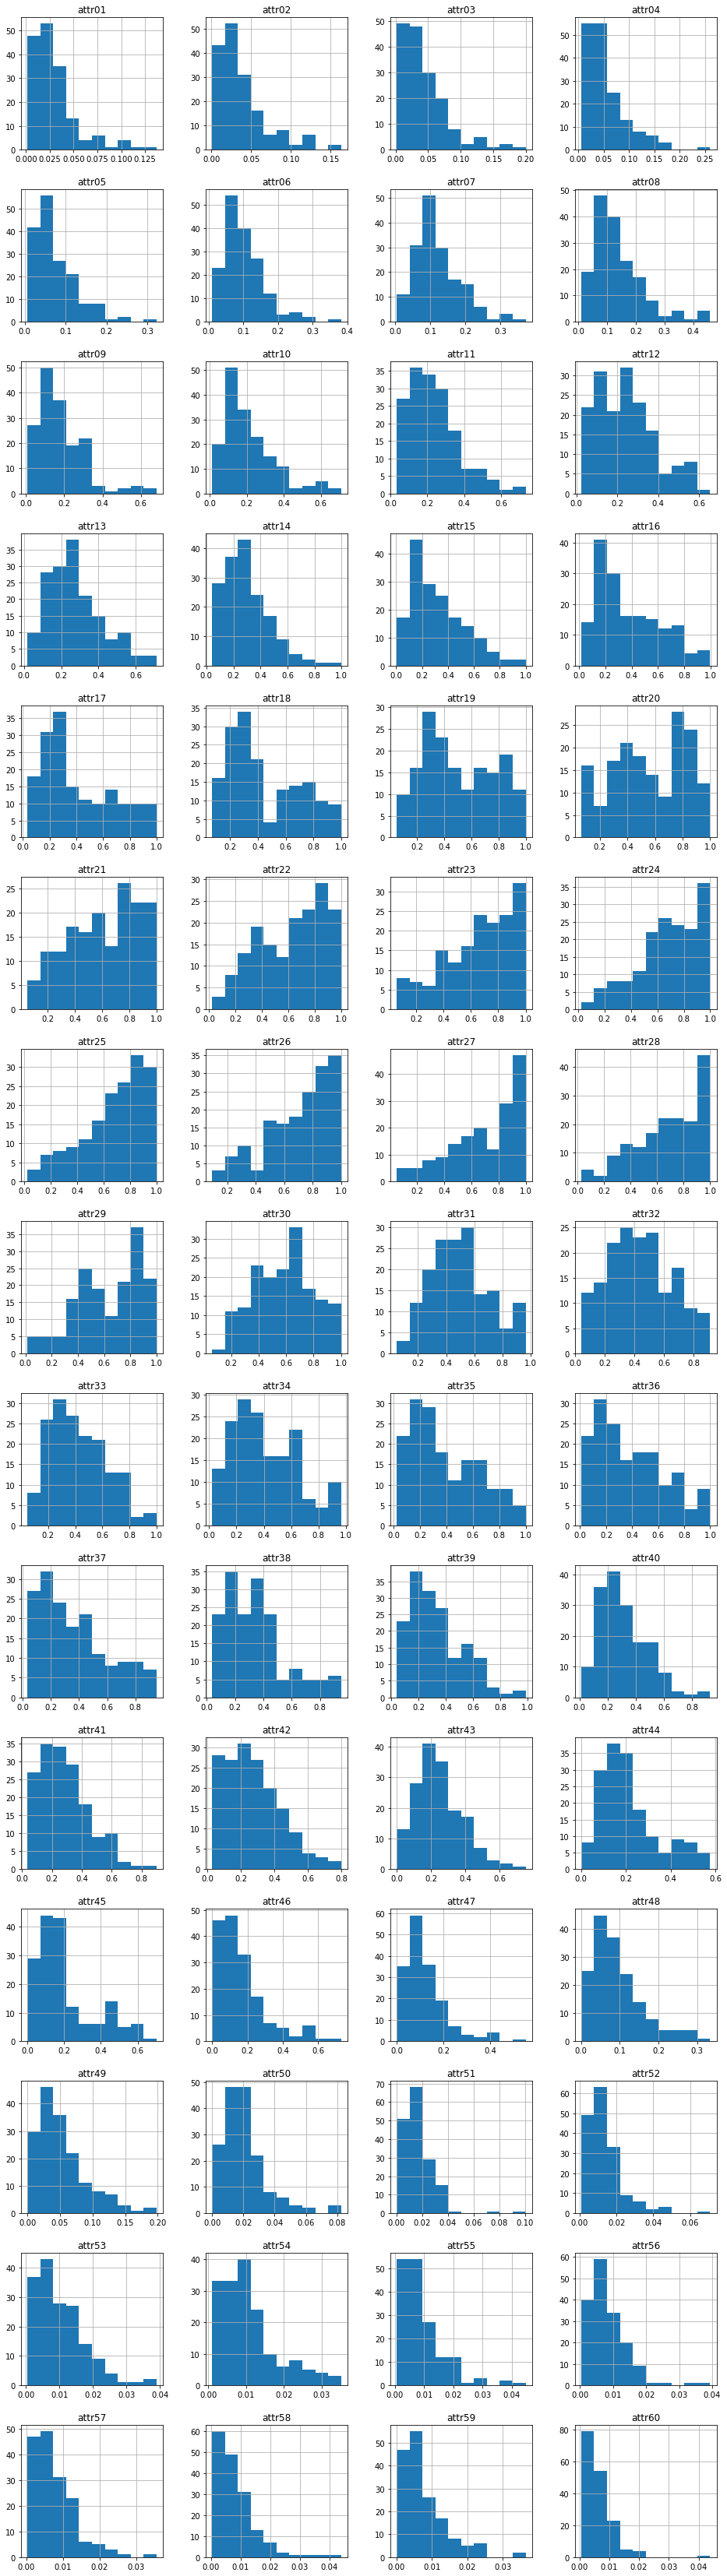

In [86]:
# Histograms for each attribute
X_train_df.hist(layout=(dispRow,dispCol))
plt.show()

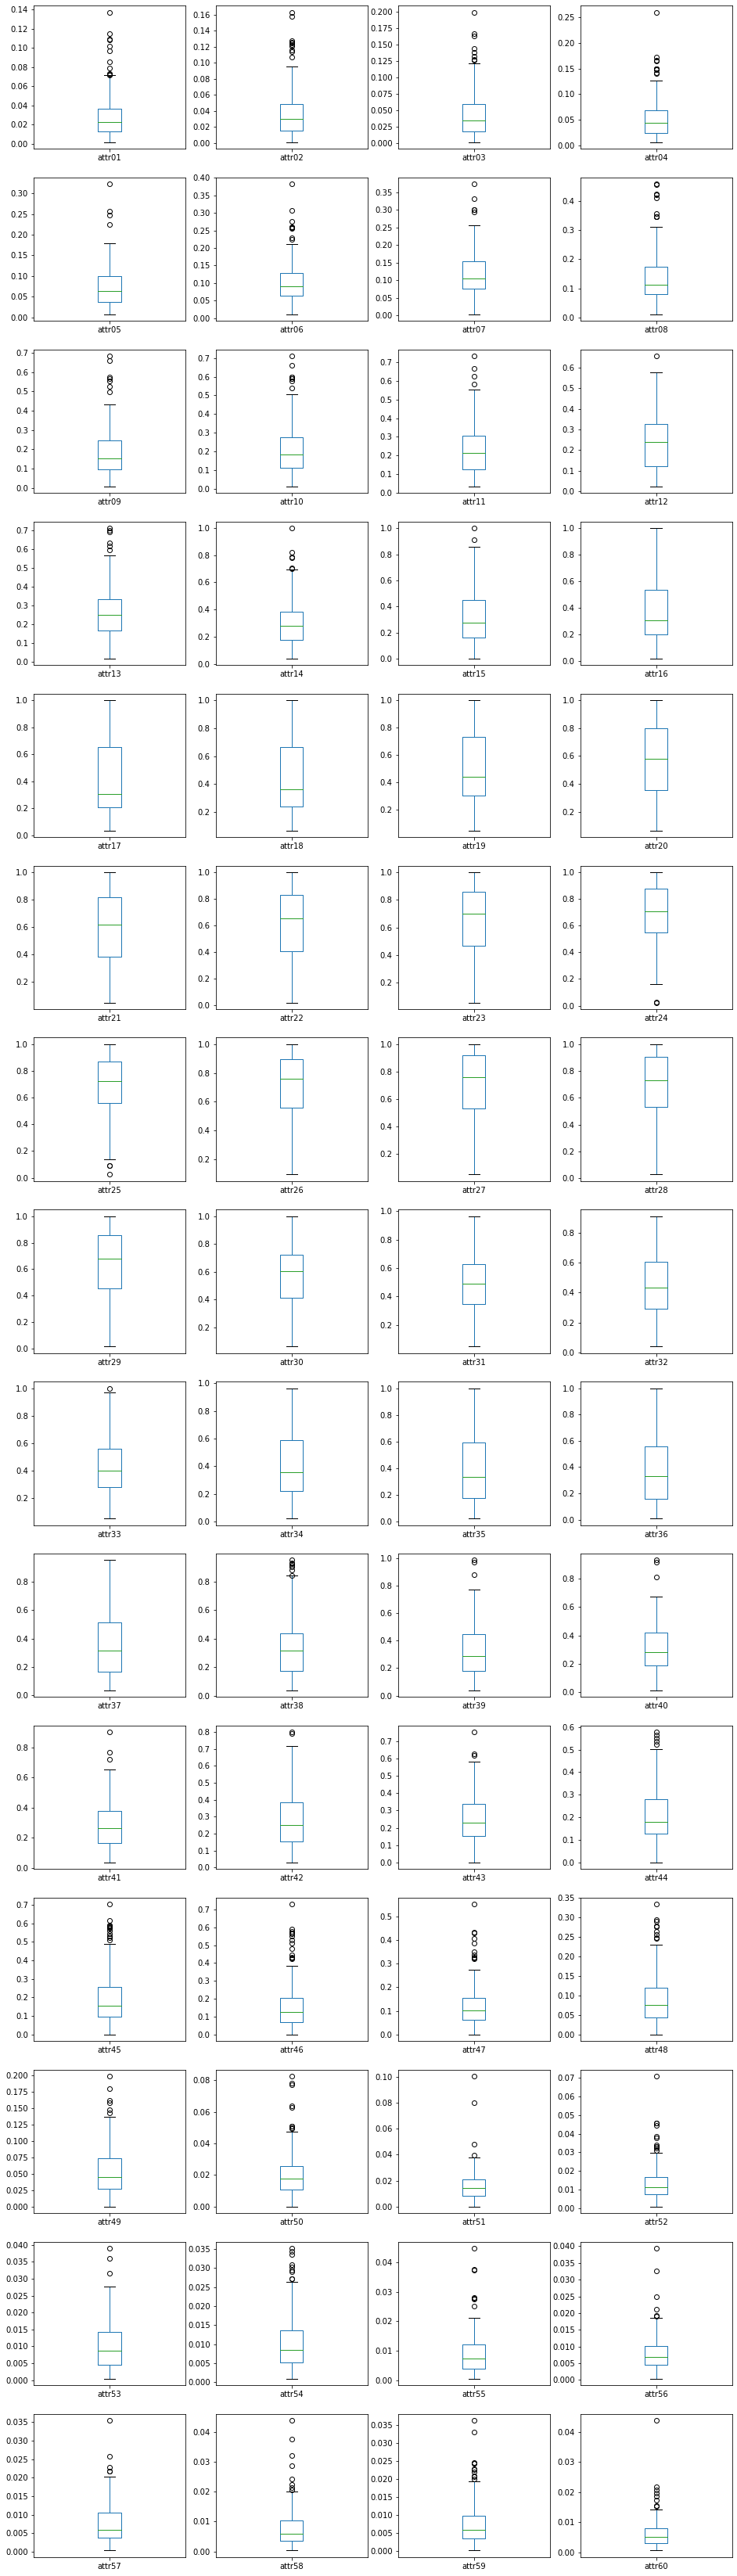

In [87]:
# Box and Whisker plot for each attribute
X_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

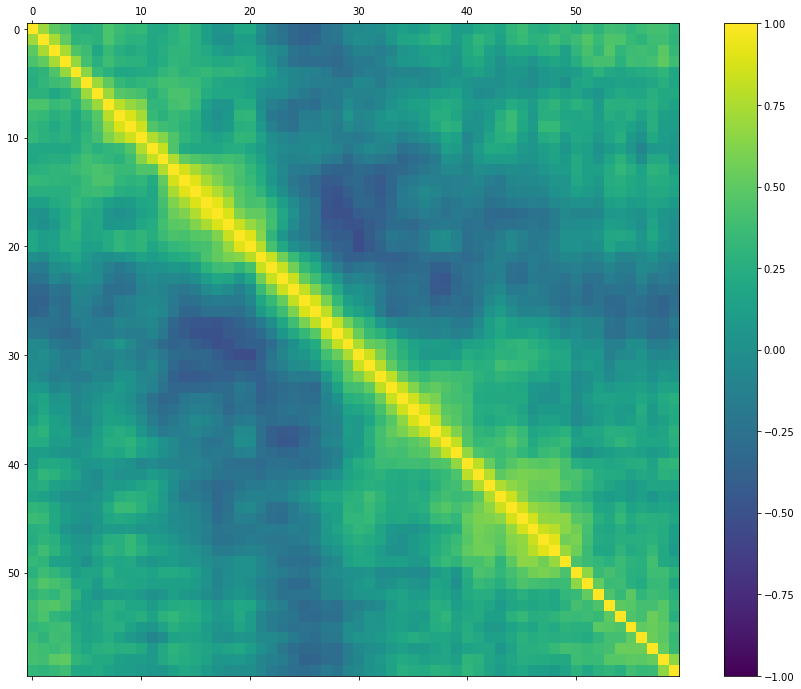

In [88]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_train_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [89]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 2 - Summarize and Visualize Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Pre-process Data

In [90]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 3 - Pre-process Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [91]:
# Compose pipeline for the numerical and categorical features
numeric_columns = X_train_df.select_dtypes(include=['int','float']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', preprocessing.PowerTransformer())
])
categorical_columns = X_train_df.select_dtypes(include=['object','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the dataframe:", X_train_df.shape[1])

Number of numerical columns: 60
Number of categorical columns: 0
Total number of columns in the dataframe: 60


In [92]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
#     ('cat', categorical_transformer, categorical_columns)
])
X_train = preprocessor.fit_transform(X_train_df)
print("Transformed X_train.shape:", X_train.shape)

Transformed X_train.shape: (166, 60)


In [93]:
# # Apply binning techniques with continuous data (Block #1 of 1)
# discrete_feature = preprocessing.Binarizer(threshold=0.0)
# discrete_feature = preprocessing.KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
# feature_binned = discrete_feature.fit_transform(X_original[['old_feature1']])
# X_train_df['new_feature1'] = feature_binned
# X_train_df['new_feature1'] = X_train_df['new_feature1'].astype('category')
# X_train_df.drop(columns=['old_feature1', 'old_feature2'], inplace=True)
# X_train_df.head()

### 3.b) Training Data Balancing

In [94]:
# Not applicable for this iteration of the project

In [95]:
# Examine the target classes for imbalanced distribution
# Xy_original.groupby('targetVar').size()

In [96]:
# # Perform SMOTE transformation on the training data (Block #1 of 2)
# X_train_imbal = X_train_df.values
# y_train_imbal = y_train_df.values.ravel()
# print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

In [97]:
# # Perform SMOTE transformation on the training data (Block #2 of 2)
# print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
# over_sample = SMOTE(sampling_strategy=0.05, random_state=seedNum)
# under_sample = RandomUnderSampler(sampling_strategy=1.0, random_state=seedNum)
# steps = [('o', over_sample), ('u', under_sample)]
# sample_pipeline = Pipeline(steps=steps)
# X_train, y_train = sample_pipeline.fit_resample(X_train_imbal, y_train_imbal)
# print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

### 3.c) Display the Final Datasets for Model-Building

In [98]:
# Finalize the training dataset for the modeling activities
class_encoder = preprocessing.LabelEncoder()
y_train = class_encoder.fit_transform(y_train_df)
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))

X_train.shape: (166, 60) y_train.shape: (166,)


In [99]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 3 - Pre-process Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Train and Evaluate Models

In [100]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 4 - Train and Evaluate Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [101]:
# Define the default numbers of input/output for modeling
num_inputs = X_train.shape[1]
num_outputs = 1

In [102]:
# Define the baseline model for benchmarking
def create_nn_model(n_inputs=num_inputs, n_outputs=num_outputs, layer1_nodes=32, layer2_nodes=32, layer1_dropout=0, layer2_dropout=0, opt_param=default_optimizer, init_param=default_kernel_init):
    nn_model = keras.Sequential([
        keras.layers.Dense(layer1_nodes, input_shape=(n_inputs,), activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer1_dropout),
        keras.layers.Dense(layer2_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer2_dropout),
        keras.layers.Dense(n_outputs, activation='sigmoid', kernel_initializer=init_param)
    ])
    nn_model.compile(loss=default_loss, optimizer=opt_param, metrics=default_metrics)
    return nn_model

In [103]:
# Initialize the default model and get a baseline result
startTimeModule = datetime.now()
results = list()
iteration = 0
cv = RepeatedKFold(n_splits=n_folds, n_repeats=n_iterations, random_state=seedNum)
reset_random(seedNum)
baseline_model = create_nn_model()
for train_ix, val_ix in cv.split(X_train):
    feature_train, feature_validation = X_train[train_ix], X_train[val_ix]
    target_train, target_validation = y_train[train_ix], y_train[val_ix]
    baseline_model.fit(feature_train, target_train, epochs=default_epoch, batch_size=default_batch, verbose=0)
    model_metric = baseline_model.evaluate(feature_validation, target_validation, verbose=0)[1]
    iteration = iteration + 1
    print('Accuracy measurement from iteration %d >>> %.2f%%' % (iteration, model_metric*100))
    results.append(model_metric)
validation_score = np.mean(results)
print('Average model accuracy from all iterations: %.3f%% (%.3f)' % (validation_score*100, np.std(results)))
print('Total time for model fitting and cross validating:', (datetime.now() - startTimeModule))

Accuracy measurement from iteration 1 >>> 79.41%
Accuracy measurement from iteration 2 >>> 84.85%
Accuracy measurement from iteration 3 >>> 100.00%
Accuracy measurement from iteration 4 >>> 100.00%
Accuracy measurement from iteration 5 >>> 100.00%
Accuracy measurement from iteration 6 >>> 100.00%
Accuracy measurement from iteration 7 >>> 100.00%
Accuracy measurement from iteration 8 >>> 100.00%
Accuracy measurement from iteration 9 >>> 100.00%
Accuracy measurement from iteration 10 >>> 100.00%
Average model accuracy from all iterations: 96.426% (0.073)
Total time for model fitting and cross validating: 0:00:01.421322


In [104]:
# Initialize the grid parameters for layer nodes
startTimeModule = datetime.now()
nodes_grid = [(48, 48), (64, 64), (96, 96), (128, 128), (192, 192)]
l1_dropout, l2_dropout = (0, 0)

# Build dataframe for reporting model performance summary
nodes_performance = pd.DataFrame(columns=['model_name', 'validation_score', 'layer1_nodes', 'layer2_nodes', 'layer1_dropout', 'layer2_dropout'])

serial_number = 0
for param in nodes_grid:
    startTimeIteration = datetime.now()
    serial_number = serial_number + 1
    model_name = "Model_" + str(serial_number).zfill(3)
    l1_nodes, l2_nodes = param
    print('Processing model %s with Layer 1: %d and Layer 2: %d nodes' % (model_name, l1_nodes, l2_nodes))
    results = list()
    iteration = 0
    cv = RepeatedKFold(n_splits=n_folds, n_repeats=n_iterations, random_state=seedNum)
    reset_random(seedNum)
    node_grid_model = create_nn_model(n_inputs=num_inputs,
                                     n_outputs=num_outputs,
                                     layer1_nodes=l1_nodes,
                                     layer2_nodes=l2_nodes,
                                     opt_param=default_optimizer,
                                     init_param=default_kernel_init)
    for train_ix, val_ix in cv.split(X_train):
        feature_train, feature_validation = X_train[train_ix], X_train[val_ix]
        target_train, target_validation = y_train[train_ix], y_train[val_ix]
        node_grid_model.fit(feature_train, target_train, epochs=default_epoch, batch_size=default_batch, verbose=0)
        model_metric = node_grid_model.evaluate(feature_validation, target_validation, verbose=0)[1]
        iteration = iteration + 1
        print('Accuracy measurement from iteration %d >>> %.2f%%' % (iteration, model_metric))
        results.append(model_metric)
    validation_score = np.mean(results)
    print('Average model accuracy from all iterations: %.2f%% (%.3f)' % (validation_score*100, np.std(results)))
    print('Total time for model fitting and cross validating:', (datetime.now() - startTimeIteration))
    print()
    nodes_performance = nodes_performance.append({'model_name': model_name, 'validation_score': validation_score, 'layer1_nodes': l1_nodes, 'layer2_nodes': l2_nodes, 'layer1_dropout': l1_dropout, 'layer2_dropout': l2_dropout}, ignore_index=True)

nodes_performance.set_index('model_name', inplace=True)
print('Total time for performing search of the best layer node parameters:', (datetime.now() - startTimeModule))

Processing model Model_001 with Layer 1: 48 and Layer 2: 48 nodes
Accuracy measurement from iteration 1 >>> 0.85%
Accuracy measurement from iteration 2 >>> 1.00%
Accuracy measurement from iteration 3 >>> 1.00%
Accuracy measurement from iteration 4 >>> 1.00%
Accuracy measurement from iteration 5 >>> 1.00%
Accuracy measurement from iteration 6 >>> 1.00%
Accuracy measurement from iteration 7 >>> 1.00%
Accuracy measurement from iteration 8 >>> 1.00%
Accuracy measurement from iteration 9 >>> 1.00%
Accuracy measurement from iteration 10 >>> 1.00%
Average model accuracy from all iterations: 98.53% (0.044)
Total time for model fitting and cross validating: 0:00:01.724391

Processing model Model_002 with Layer 1: 64 and Layer 2: 64 nodes
Accuracy measurement from iteration 1 >>> 0.79%
Accuracy measurement from iteration 2 >>> 1.00%
Accuracy measurement from iteration 3 >>> 1.00%
Accuracy measurement from iteration 4 >>> 1.00%
Accuracy measurement from iteration 5 >>> 1.00%
Accuracy measurement 

In [105]:
# Display the model performance summary
nodes_performance.sort_values(by=['validation_score'], ascending=False).head()

,validation_score,layer1_nodes,layer2_nodes,layer1_dropout,layer2_dropout
model_name,,,,,
Model_001,0.985294,48,48,0,0
Model_004,0.985294,128,128,0,0
Model_005,0.982353,192,192,0,0
Model_002,0.979412,64,64,0,0
Model_003,0.976471,96,96,0,0


In [106]:
# Initialize the grid parameters for the dropout ratio
startTimeModule = datetime.now()
l1_nodes = 64
l2_nodes = 64
l1_dropout_grid = [0, 0.25, 0.5]
l2_dropout_grid = [0, 0.5]

# Build dataframe for reporting model performance summary
dropout_performance = pd.DataFrame(columns=['model_name','validation_score','layer1_nodes','layer2_nodes','layer1_dropout','layer2_dropout'])

serial_number = 0
for l1_dropout in l1_dropout_grid:
    for l2_dropout in l2_dropout_grid:
        startTimeIteration = datetime.now()
        serial_number = serial_number + 1
        model_name = "Model_" + str(serial_number).zfill(3)
        print('Processing model %s with Layer 1: %d and Layer 2: %d nodes and dropout parameters of Layer 1: %.2f and Layer 2: %.2f' % (model_name, l1_nodes, l2_nodes, l1_dropout, l2_dropout))
        results = list()
        iteration = 0
        cv = RepeatedKFold(n_splits=n_folds, n_repeats=n_iterations, random_state=seedNum)
        reset_random(seedNum)
        dropout_grid_model = create_nn_model(n_inputs=num_inputs,
                                            n_outputs=num_outputs,
                                            layer1_nodes=l1_nodes,
                                            layer2_nodes=l2_nodes,
                                            layer1_dropout=l1_dropout,
                                            layer2_dropout=l2_dropout,
                                            opt_param=default_optimizer,
                                            init_param=default_kernel_init)
        for train_ix, val_ix in cv.split(X_train):
            feature_train, feature_validation = X_train[train_ix], X_train[val_ix]
            target_train, target_validation = y_train[train_ix], y_train[val_ix]
            dropout_grid_model.fit(feature_train, target_train, epochs=default_epoch, batch_size=default_batch, verbose=0)
            model_metric = dropout_grid_model.evaluate(feature_validation, target_validation, verbose=0)[1]
            iteration = iteration + 1
            print('Accuracy measurement from iteration %d >>> %.2f%%' % (iteration, model_metric*100))
            results.append(model_metric)
        validation_score = np.mean(results)
        print('Average model accuracy from all iterations: %.2f%% (%.3f)' % (validation_score*100, np.std(results)))
        print('Total time for model fitting and cross validating:', (datetime.now() - startTimeIteration))
        print()
        dropout_performance = dropout_performance.append({'model_name': model_name, 'validation_score': validation_score, 'layer1_nodes': l1_nodes, 'layer2_nodes': l2_nodes, 'layer1_dropout': l1_dropout, 'layer2_dropout': l2_dropout}, ignore_index=True)

dropout_performance.set_index('model_name', inplace=True)
print('Total time for performing grid-search of the best dropout parameters:', (datetime.now() - startTimeModule))

Processing model Model_001 with Layer 1: 64 and Layer 2: 64 nodes and dropout parameters of Layer 1: 0.00 and Layer 2: 0.00
Accuracy measurement from iteration 1 >>> 82.35%
Accuracy measurement from iteration 2 >>> 100.00%
Accuracy measurement from iteration 3 >>> 100.00%
Accuracy measurement from iteration 4 >>> 100.00%
Accuracy measurement from iteration 5 >>> 100.00%
Accuracy measurement from iteration 6 >>> 100.00%
Accuracy measurement from iteration 7 >>> 100.00%
Accuracy measurement from iteration 8 >>> 100.00%
Accuracy measurement from iteration 9 >>> 100.00%
Accuracy measurement from iteration 10 >>> 100.00%
Average model accuracy from all iterations: 98.24% (0.053)
Total time for model fitting and cross validating: 0:00:01.458329

Processing model Model_002 with Layer 1: 64 and Layer 2: 64 nodes and dropout parameters of Layer 1: 0.00 and Layer 2: 0.50
Accuracy measurement from iteration 1 >>> 76.47%
Accuracy measurement from iteration 2 >>> 100.00%
Accuracy measurement from i

In [107]:
# Display the model performance summary
dropout_performance.sort_values(by=['validation_score'], ascending=False).head()

,validation_score,layer1_nodes,layer2_nodes,layer1_dropout,layer2_dropout
model_name,,,,,
Model_001,0.982353,64,64,0,0
Model_002,0.976471,64,64,0,0.5
Model_003,0.976381,64,64,0.25,0
Model_004,0.976292,64,64,0.25,0.5
Model_005,0.976203,64,64,0.5,0


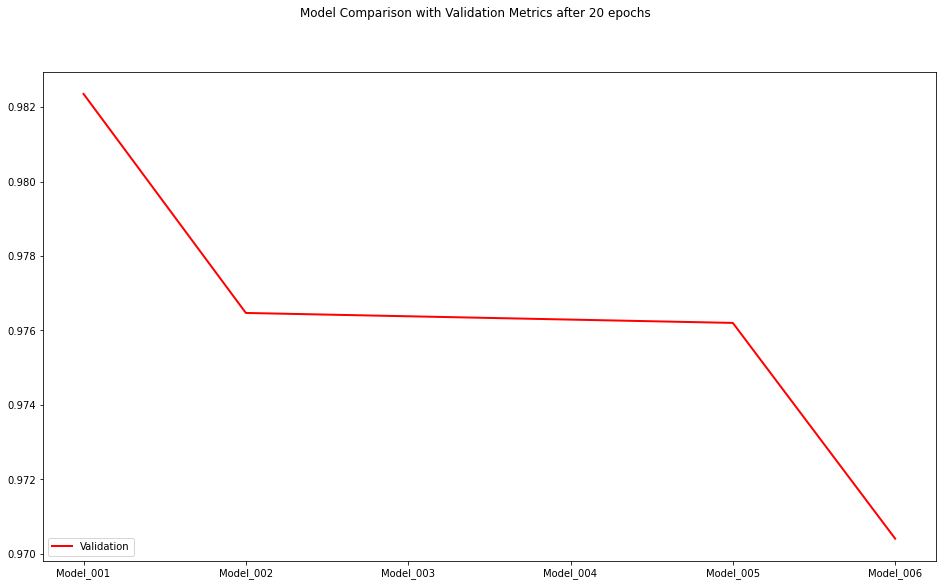

In [108]:
# Spot-checking the models
fig = plt.figure(figsize=(16,9))
title = 'Model Comparison with Validation Metrics after ' + str(default_epoch) + ' epochs'
fig.suptitle(title)
ax1 = fig.add_subplot(111)
ax1.plot(dropout_performance['validation_score'], color='r', lw=2.)
plt.legend(['Validation'], loc='lower left')
plt.show()

In [109]:
# Create the final model for evaluating the test dataset
model_to_use = 'Model_001'
final_l1_nodes = dropout_performance.loc[model_to_use]['layer1_nodes']
final_l2_nodes = dropout_performance.loc[model_to_use]['layer2_nodes']
final_l1_dropout = dropout_performance.loc[model_to_use]['layer1_dropout']
final_l2_dropout = dropout_performance.loc[model_to_use]['layer2_dropout']
final_optimizer = default_optimizer
final_kernel_init = default_kernel_init
final_epoch = default_epoch
final_batch = default_batch
print('Fitting final model with Layer 1: %d, Layer 2: %d with dropout parameters of Layer 1: %.2f, Layer 2: %.2f' % (final_l1_nodes, final_l2_nodes, final_l1_dropout, final_l2_dropout))
reset_random(seedNum)
final_model = create_nn_model(n_inputs=num_inputs,
                              n_outputs=num_outputs,
                              layer1_nodes=final_l1_nodes,
                              layer2_nodes=final_l2_nodes,
                              layer1_dropout=final_l1_dropout,
                              layer2_dropout=final_l2_dropout,
                              opt_param=final_optimizer,
                              init_param=final_kernel_init)
final_model.fit(X_train, y_train, epochs=final_epoch, batch_size=final_batch, verbose=1)

Fitting final model with Layer 1: 64, Layer 2: 64 with dropout parameters of Layer 1: 0.00, Layer 2: 0.00
Epoch 1/20
6/6 [==============================] - 0s 667us/step - loss: 0.6502 - accuracy: 0.6205
Epoch 2/20
6/6 [==============================] - 0s 667us/step - loss: 0.3541 - accuracy: 0.8494
Epoch 3/20
6/6 [==============================] - 0s 667us/step - loss: 0.2396 - accuracy: 0.8916
Epoch 4/20
6/6 [==============================] - 0s 667us/step - loss: 0.1526 - accuracy: 0.9518
Epoch 5/20
6/6 [==============================] - 0s 667us/step - loss: 0.0960 - accuracy: 0.9759
Epoch 6/20
6/6 [==================

In [110]:
# Summarize the final model
final_model.summary()

Model: "sequential_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_402 (Dense)            (None, 64)                3904      
_________________________________________________________________
dropout_268 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_403 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_269 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_404 (Dense)            (None, 1)                 65        
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


In [111]:
# Display the configuration details of the final model
final_model.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential_134", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 60], "dtype": "float32", "sparse": false, "ragged": false, "name": "dense_402_input"}}, {"class_name": "Dense", "config": {"name": "dense_402", "trainable": true, "batch_input_shape": [null, 60], "dtype": "float32", "units": 64, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": 888}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dropout", "config": {"name": "dropout_268", "trainable": true, "dtype": "float32", "rate": 0, "noise_shape": null, "seed": null}}, {"class_name": "Dense", "config": {"name": "dense_403", "trainable": true, "dtype": "float32", "units": 64, "activation": "relu", "use_bias": true, "kernel_initi

In [112]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 4 - Train and Evaluate Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Present Analysis

In [113]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 5 - Finalize Model and Present Analysis has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [114]:
# Apply the same data preparation steps to the test dataset
X_test = preprocessor.transform(X_test_df)
# Encode the target variable
y_test = class_encoder.transform(y_test_df)
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_test.shape: (42, 60) y_test.shape: (42,)


In [115]:
# test_predictions = final_model.predict(X_test, batch_size=default_batch, verbose=1)
test_predictions = (final_model.predict(X_test) > 0.5).astype("int32").ravel()
print('Accuracy Score:', accuracy_score(y_test, test_predictions))
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))

Accuracy Score: 0.7857142857142857
[[21  1]
 [ 8 12]]
              precision    recall  f1-score   support

           0       0.72      0.95      0.82        22
           1       0.92      0.60      0.73        20

    accuracy                           0.79        42
   macro avg       0.82      0.78      0.78        42
weighted avg       0.82      0.79      0.78        42



In [116]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 5 - Finalize Model and Present Analysis completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [117]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:30.885363
